In [18]:
!pip install tensorflow
!pip install transformers
!pip install pandas
!pip install scikit-learn
!pip install tf-keras

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [20]:
try:
    df = pd.read_csv('/kaggle/input/adfesrgdthdg/cauhoimau.csv')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'cauhoimau.csv'.")
    print("Hãy đảm bảo file này nằm cùng thư mục với sổ tay Jupyter hoặc cung cấp đường dẫn chính xác.")
    df = pd.DataFrame(columns=['Câu hỏi', 'Mã Ngành', 'Mã Mục'])


print("5 dòng đầu của dữ liệu:")
print(df.head())
print(f"\nTổng số mẫu dữ liệu: {len(df)}")
print("\nThông tin chung về dữ liệu:")
df.info()

if not df.empty:
    print(f"\nSố lượng 'Mã Ngành' duy nhất: {df['Mã Ngành'].nunique()}")
    print(f"Các 'Mã Ngành' duy nhất: {df['Mã Ngành'].unique()}")
    print(f"\nSố lượng 'Mã Mục' duy nhất: {df['Mã Mục'].nunique()}")
    print(f"Các 'Mã Mục' duy nhất: {df['Mã Mục'].unique()}")
else:
    print("\nDataFrame rỗng, không thể phân tích nhãn.")

5 dòng đầu của dữ liệu:
                                             Câu hỏi Mã Ngành  Mã Mục
0  Ngành Mạng máy tính và Truyền thông dữ liệu họ...        I       1
1  Tên văn bằng tiếng Anh của ngành Mạng máy tính...        I       1
2  Mục tiêu chung của chương trình đào tạo Kỹ sư ...        I       2
3  Ngành Mạng máy tính và Truyền thông dữ liệu đà...        I       2
4  Thông tin tuyển sinh chi tiết của ngành Mạng m...        I       3

Tổng số mẫu dữ liệu: 653

Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Câu hỏi   653 non-null    object
 1   Mã Ngành  653 non-null    object
 2   Mã Mục    653 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 15.4+ KB

Số lượng 'Mã Ngành' duy nhất: 20
Các 'Mã Ngành' duy nhất: ['I' 'II' 'III' 'IV' 'V' 'VI' 'VII' 'VIII' 'IX' 'X' 'XI' 'XII' 'XIII'
 'XIV' 'XV' 'XVI' 'XVII' 'X

In [21]:
if not df.empty:
    df.dropna(subset=['Câu hỏi', 'Mã Ngành', 'Mã Mục'], inplace=True)
    df['Câu hỏi'] = df['Câu hỏi'].astype(str)

    encoder_nganh = LabelEncoder()
    df['label_nganh'] = encoder_nganh.fit_transform(df['Mã Ngành'].astype(str))
    num_classes_nganh = len(encoder_nganh.classes_)
    print(f"Số lớp cho Mã Ngành: {num_classes_nganh}")
    print(f"Mapping Mã Ngành: {dict(zip(encoder_nganh.classes_, encoder_nganh.transform(encoder_nganh.classes_)))}")

    encoder_muc = LabelEncoder()
    df['label_muc'] = encoder_muc.fit_transform(df['Mã Mục'].astype(str))
    num_classes_muc = len(encoder_muc.classes_)
    print(f"Số lớp cho Mã Mục: {num_classes_muc}")
    print(f"Mapping Mã Mục: {dict(zip(encoder_muc.classes_, encoder_muc.transform(encoder_muc.classes_)))}")

    train_texts, test_texts, train_labels_nganh, test_labels_nganh, train_labels_muc, test_labels_muc = train_test_split(
        df['Câu hỏi'].tolist(),
        df['label_nganh'].tolist(),
        df['label_muc'].tolist(),
        test_size=0.2,
        random_state=42
    )
    print(f"\nSố mẫu huấn luyện: {len(train_texts)}")
    print(f"Số mẫu kiểm tra: {len(test_texts)}")
else:
    print("DataFrame rỗng, bỏ qua bước tiền xử lý.")
    train_texts, test_texts, train_labels_nganh, test_labels_nganh, train_labels_muc, test_labels_muc = [], [], [], [], [], []
    num_classes_nganh = 0
    num_classes_muc = 0
    encoder_nganh = None
    encoder_muc = None

Số lớp cho Mã Ngành: 20
Mapping Mã Ngành: {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'IX': 4, 'V': 5, 'VI': 6, 'VII': 7, 'VIII': 8, 'X': 9, 'XI': 10, 'XII': 11, 'XIII': 12, 'XIV': 13, 'XIX': 14, 'XV': 15, 'XVI': 16, 'XVII': 17, 'XVIII': 18, 'XX': 19}
Số lớp cho Mã Mục: 7
Mapping Mã Mục: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}

Số mẫu huấn luyện: 522
Số mẫu kiểm tra: 131


In [22]:
MODEL_NAME = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 128 

if train_texts and test_texts:
    train_encodings = tokenizer(
        train_texts,
        truncation=True,
        padding='max_length', 
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    test_encodings = tokenizer(
        test_texts,
        truncation=True,
        padding='max_length', 
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

    print("Shape sau khi tokenize (train_encodings['input_ids']):", train_encodings['input_ids'].shape)
    print("Shape sau khi tokenize (test_encodings['input_ids']):", test_encodings['input_ids'].shape)


    train_labels_nganh = np.array(train_labels_nganh)
    test_labels_nganh = np.array(test_labels_nganh)
    train_labels_muc = np.array(train_labels_muc)
    test_labels_muc = np.array(test_labels_muc)
else:
    print("Không có dữ liệu huấn luyện/kiểm tra để tokenize.")
    train_encodings, test_encodings = None, None

Shape sau khi tokenize (train_encodings['input_ids']): (522, 128)
Shape sau khi tokenize (test_encodings['input_ids']): (131, 128)


In [23]:
def create_multitask_transformer_model(model_name, num_labels_nganh, num_labels_muc, max_length=MAX_LENGTH):
    transformer_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
    
    transformer_output = transformer_model(input_ids, attention_mask=attention_mask)[0]
    cls_token_output = transformer_output[:, 0, :]
    dropout_layer = tf.keras.layers.Dropout(0.1)(cls_token_output)

    output_nganh = tf.keras.layers.Dense(num_labels_nganh, activation='softmax', name='output_nganh')(dropout_layer)
    output_muc = tf.keras.layers.Dense(num_labels_muc, activation='softmax', name='output_muc')(dropout_layer)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output_nganh, output_muc])

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer,
                  loss={'output_nganh': 'sparse_categorical_crossentropy',
                        'output_muc': 'sparse_categorical_crossentropy'},
                  metrics={'output_nganh': 'accuracy',
                           'output_muc': 'accuracy'})
    return model

if num_classes_nganh > 0 and num_classes_muc > 0:
    model = create_multitask_transformer_model(MODEL_NAME, num_classes_nganh, num_classes_muc)
    model.summary()
else:
    print("Không đủ số lớp để tạo mô hình (cần > 0 cho cả Mã Ngành và Mã Mục).")
    model = None

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model_2 (TFRobe  TFBaseModelOutputWithPooli   1349982   ['input_ids[0][0]',           
 rtaModel)                   ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

In [24]:
EPOCHS = 50
BATCH_SIZE = 16
print("Shape of train_encodings['input_ids']:", train_encodings['input_ids'].shape)
print("Shape of train_encodings['attention_mask']:", train_encodings['attention_mask'].shape)
print("Shape of test_encodings['input_ids']:", test_encodings['input_ids'].shape)
print("Shape of test_encodings['attention_mask']:", test_encodings['attention_mask'].shape)
if model and train_encodings and test_encodings:
    print("\nBắt đầu quá trình huấn luyện...")
    history = model.fit(
        {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
        {'output_nganh': train_labels_nganh, 'output_muc': train_labels_muc},
        validation_data=(
            {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
            {'output_nganh': test_labels_nganh, 'output_muc': test_labels_muc}
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    print("Hoàn thành huấn luyện.")
else:
    print("Không thể huấn luyện do mô hình hoặc dữ liệu chưa được chuẩn bị.")
    history = None

Shape of train_encodings['input_ids']: (522, 128)
Shape of train_encodings['attention_mask']: (522, 128)
Shape of test_encodings['input_ids']: (131, 128)
Shape of test_encodings['attention_mask']: (131, 128)

Bắt đầu quá trình huấn luyện...
Epoch 1/50
33/33 [==============================] - 66s 633ms/step - loss: 4.2471 - output_nganh_loss: 2.7872 - output_muc_loss: 1.4598 - output_nganh_accuracy: 0.2031 - output_muc_accuracy: 0.5077 - val_loss: 2.5025 - val_output_nganh_loss: 1.8310 - val_output_muc_loss: 0.6715 - val_output_nganh_accuracy: 0.6565 - val_output_muc_accuracy: 0.8931
Epoch 2/50
33/33 [==============================] - 16s 498ms/step - loss: 1.8109 - output_nganh_loss: 1.2169 - output_muc_loss: 0.5939 - output_nganh_accuracy: 0.8391 - output_muc_accuracy: 0.8908 - val_loss: 0.7363 - val_output_nganh_loss: 0.3320 - val_output_muc_loss: 0.4043 - val_output_nganh_accuracy: 1.0000 - val_output_muc_accuracy: 0.9237
Epoch 3/50
33/33 [==============================] - 16s 487ms


Đánh giá mô hình trên tập kiểm tra:
9/9 [==============================] - 1s 142ms/step - loss: 0.1215 - output_nganh_loss: 0.0016 - output_muc_loss: 0.1199 - output_nganh_accuracy: 1.0000 - output_muc_accuracy: 0.9771
Test Loss: 0.12152883410453796
Test Loss Ngành: 0.001614714739844203
Test Loss Mục: 0.11991412192583084
Test Accuracy Ngành: 1.0
Test Accuracy Mục: 0.9770992398262024


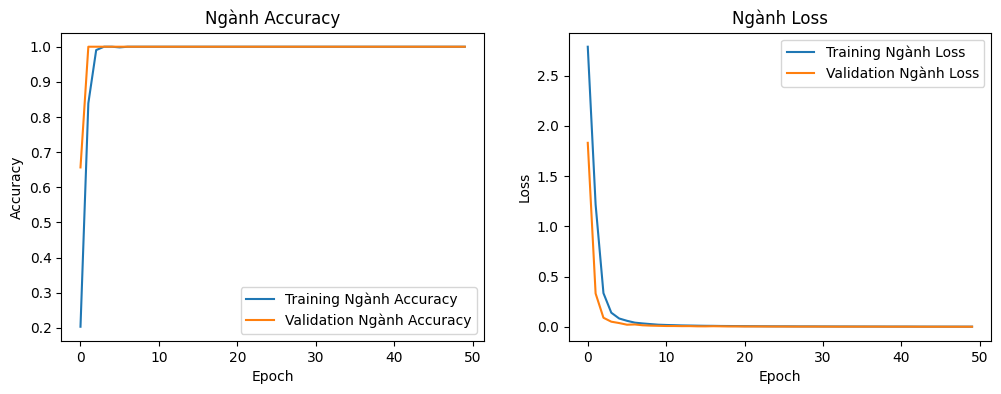

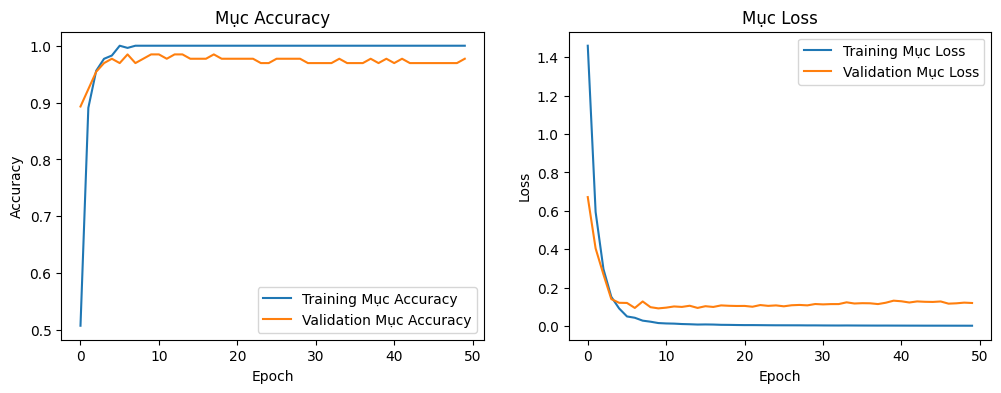

In [25]:
if model and test_encodings and history:
    print("\nĐánh giá mô hình trên tập kiểm tra:")
    results = model.evaluate(
        {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
        {'output_nganh': test_labels_nganh, 'output_muc': test_labels_muc},
        batch_size=BATCH_SIZE
    )
    print(f"Test Loss: {results[0]}")
    print(f"Test Loss Ngành: {results[1]}")
    print(f"Test Loss Mục: {results[2]}")
    print(f"Test Accuracy Ngành: {results[3]}")
    print(f"Test Accuracy Mục: {results[4]}")

    import matplotlib.pyplot as plt

    if history:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['output_nganh_accuracy'], label='Training Ngành Accuracy')
        plt.plot(history.history['val_output_nganh_accuracy'], label='Validation Ngành Accuracy')
        plt.title('Ngành Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['output_nganh_loss'], label='Training Ngành Loss')
        plt.plot(history.history['val_output_nganh_loss'], label='Validation Ngành Loss')
        plt.title('Ngành Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['output_muc_accuracy'], label='Training Mục Accuracy')
        plt.plot(history.history['val_output_muc_accuracy'], label='Validation Mục Accuracy')
        plt.title('Mục Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['output_muc_loss'], label='Training Mục Loss')
        plt.plot(history.history['val_output_muc_loss'], label='Validation Mục Loss')
        plt.title('Mục Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
else:
    print("Chưa có mô hình hoặc dữ liệu để đánh giá.")

In [26]:
import os
import joblib

if model and history: 
    print("\nBắt đầu quá trình lưu mô hình...")
    
    model_save_path = './saved_model/my_multitask_transformer_model'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    try:
        model.save(model_save_path)
        print(f"Đã lưu toàn bộ mô hình vào: {model_save_path}")
    except Exception as e:
        print(f"Lỗi khi lưu toàn bộ mô hình: {e}")
        print("Đang thử lưu chỉ trọng số...")
        weights_save_path = os.path.join(model_save_path, 'model_weights.weights.h5')
        try:
            model.save_weights(weights_save_path)
            print(f"Đã lưu chỉ trọng số của mô hình vào: {weights_save_path}")
            print("Lưu ý: Khi tải lại, bạn cần định nghĩa lại kiến trúc mô hình trước.")
        except Exception as e_weights:
            print(f"Lỗi khi lưu trọng số: {e_weights}")

    try:
        if 'encoder_nganh' in globals() and encoder_nganh: 
            joblib.dump(encoder_nganh, os.path.join(model_save_path, 'encoder_nganh.joblib'))
            print(f"Đã lưu encoder_nganh vào: {os.path.join(model_save_path, 'encoder_nganh.joblib')}")
        if 'encoder_muc' in globals() and encoder_muc: 
            joblib.dump(encoder_muc, os.path.join(model_save_path, 'encoder_muc.joblib'))
            print(f"Đã lưu encoder_muc vào: {os.path.join(model_save_path, 'encoder_muc.joblib')}")
    except Exception as e_encoder:
        print(f"Lỗi khi lưu encoders: {e_encoder}")
        
    print("Hoàn thành lưu mô hình và encoders.")
    
else:
    print("Mô hình chưa được huấn luyện hoặc không tồn tại để lưu.")


Bắt đầu quá trình lưu mô hình...
Đã lưu toàn bộ mô hình vào: ./saved_model/my_multitask_transformer_model
Đã lưu encoder_nganh vào: ./saved_model/my_multitask_transformer_model/encoder_nganh.joblib
Đã lưu encoder_muc vào: ./saved_model/my_multitask_transformer_model/encoder_muc.joblib
Hoàn thành lưu mô hình và encoders.
